### MGMTMFE406-2 Derivative Markets
#### Project 1 - Pricing European/Asian Options and American Options Using Longstaff and Schwartz Least-Square Method
February 18, 2019
Hyeuk Jung, MFE2019

In [1]:
#
# Project1_Jung_Hyeuk.py
# MGMTMFE406-2 Derivative Markets - Project 1
# Hyeuk Jung (005259560)
#

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import *

def binom(type, S0, K, r, h, u, d, T, D, div): #sd, n: # nodes
    # parameters needed for option valuation
    n = T
    p = (exp(r*h) - d) / (u-d) # risk-neutral probability
    discount = exp((-1)*r*h)
    
    ##### Stock paths -------------------------------------------------------------
    stocks = np.zeros((n+1,n+1))
    stocks[0,0] = S0
    if div == 0:
        for i in range(1, n+1, 1): # column
            stocks[0, i] = stocks[0, 0]*(u**i)
            for j in range(1, i+1, 1): # row
                stocks[j, i] = stocks[j-1,i-1]*d #(d**j)
    
    elif div != 0:
        for i in range(1, n+1, 1): # column

            if i-1 in D:
                div_number = D.index(i-1)+1
                stocks[0, i] = stocks[0, 0]*(u**i) * (1 - div)**div_number
                for j in range(1, i+1, 1): # row
                    stocks[j, i] = stocks[j-1,i-1]*d * (1 - div)**div_number
            else:
                stocks[0, i] = stocks[0, 0]*(u**i)
                #stocks[0, i] = stocks[0, 0]*(u**i)
                for j in range(1, i+1, 1): # row
                    stocks[j, i] = stocks[j-1,i-1]*d #(d**j)   
            
    ##### Option valuation --------------------------------------------------------
    option = np.zeros((n+1,n+1))
    delta = np.zeros((n+1,n+1))
    bond = np.zeros((n+1,n+1))  
    ### European call
    if(type == "EC"): # call paths
        # final nodes
        option[:, n] = np.maximum(stocks[:, n] - K, 0)

        for j in range(n-1, -1, -1): # row
            for i in range(j, -1, -1): # column
                option[i, j] = discount*(p*option[i, j+1] + (1-p)*option[i+1, j+1])
                delta[i, j] = (option[i, j+1] - option[i+1, j+1]) / (stocks[i, j]*(u-d))
                bond[i, j] = discount * (option[i+1, j+1]*u - option[i, j+1]*d) / (u-d)
        
    ### European put
    elif(type == "EP"):
        #final nodes
        option[:, n] = np.maximum(K - stocks[:, n], 0)    

        for j in range(n-1, -1, -1):
            for i in range(j, -1, -1):
                option[i, j] = discount*(p*option[i, j+1] + (1-p)*option[i+1, j+1])
                delta[i, j] = (option[i, j+1] - option[i+1, j+1]) / (stocks[i, j]*(u-d))
                bond[i, j] = discount * (option[i+1, j+1]*u - option[i, j+1]*d) / (u-d)
    
    ### European binary call
    elif(type == "EBC"): # call paths
        # final nodes
        option[:, n] = np.where(stocks[:, n] > K, K, 0)

        for j in range(n-1, -1, -1): # row
            for i in range(j, -1, -1): # column
                option[i, j] = discount*(p*option[i, j+1] + (1-p)*option[i+1, j+1])
                delta[i, j] = (option[i, j+1] - option[i+1, j+1]) / (stocks[i, j]*(u-d))
                bond[i, j] = discount * (option[i+1, j+1]*u - option[i, j+1]*d) / (u-d)

    ### American call
    elif(type == "AC"): # call paths
        # final nodes (exercise value)
        option[:, n] = np.maximum(stocks[:, n] - K, 0)

        for i in range(n-1, -1, -1): # row
            for j in range(n-1, i-1, -1): # column
                # exercise value
                ev = max(stocks[i, j] - K, 0)
                # continuation value
                cv = discount*(p*option[i, j+1] + (1-p)*option[i+1, j+1])
                option[i, j] = np.maximum(ev, cv) 
                delta[i, j] = (option[i, j+1] - option[i+1, j+1]) / (stocks[i, j]*(u-d))
                bond[i, j] = discount * (option[i+1, j+1]*u - option[i, j+1]*d) / (u-d)
    
    ### American put
    elif(type == "AP"):
        #final nodes (exercise value)
        option[:, n] = np.maximum(K - stocks[:, n], 0)  
        
        for i in range(n-1, -1, -1):
            for j in range(n-1, i-1, -1):
                ev = max(K - stocks[i, j], 0)
                cv = discount*(p*option[i, j+1] + (1-p)*option[i+1, j+1])
                option[i, j] = np.maximum(ev, cv)
                delta[i, j] = (option[i, j+1] - option[i+1, j+1]) / (stocks[i, j]*(u-d))
                bond[i, j] = discount * (option[i+1, j+1]*u - option[i, j+1]*d) / (u-d)
    
    ### American straddle
    elif(type == "AStraddle"):
        ap = np.maximum(K - stocks[:, n], 0)  
        ac = np.maximum(stocks[:, n] - K, 0)
        option[:, n] = ap + ac # straddle
        
        for i in range(n-1, -1, -1):
            for j in range(n-1, i-1, -1):
                ev = np.abs(stocks[i, j] - K) # consider american put and call at the same time
                cv = discount*(p*option[i, j+1] + (1-p)*option[i+1, j+1])
                option[i, j] = np.maximum(ev, cv)
                delta[i, j] = (option[i, j+1] - option[i+1, j+1]) / (stocks[i, j]*(u-d))
                bond[i, j] = discount * (option[i+1, j+1]*u - option[i, j+1]*d) / (u-d)

    return option[0, 0], delta, bond


# 1. Pricing European Options
# 1. (a) Straddle strategy value - Long put and long call
S0 = 100; K = 90; r = 0.02; h = 0.25; T = 4
u = exp(r*h + 0.2*sqrt(h)); d = exp(r*h - 0.2*sqrt(h))
q1a_long_call, q1a_long_call_d, q1a_long_call_b = binom("EC", S0, K, r, h, u, d, T, D = 0, div = 0)
q1a_long_put, q1a_long_put_d, q1a_long_put_b = binom("EP", S0, K, r, h, u, d, T, D = 0, div = 0)
print('1 (a). Straddle value: ', q1a_long_call + q1a_long_put)

# 1. (b) Straddle strategy value - Long put and long call
S0 = 100; K = 90; r = 0.02; h = 0.025; T = 40
u = exp(r*h + 0.2*sqrt(h)); d = exp(r*h - 0.2*sqrt(h))
q1b_long_call, q1b_long_call_d, q1b_long_call_b = binom("EC", S0, K, r, h, u, d, T, D = 0, div = 0)
q1b_long_put, q1b_long_put_d, q1b_long_put_b = binom("EP", S0, K, r, h, u, d, T, D = 0, div = 0)
print('1 (b). Straddle value: ', q1b_long_call + q1b_long_put)

# 1. (c) Straddle strategy value - binary call option
S0 = 100; K = 90; r = 0.02; h = 0.25; T = 4
u = exp(r*h + 0.2*sqrt(h)); d = exp(r*h - 0.2*sqrt(h))
q1c_binary_call, q1c_binary_call_d, q1c_binary_call_b = binom("EBC", S0, K, r, h, u, d, T, D = 0, div = 0)
print('1 (c). Binary call value: ', q1c_binary_call)



1 (a). Straddle value:  18.489122508233876
1 (b). Straddle value:  17.755453809334256
1 (c). Binary call value:  57.26466279141384


In [2]:
# 2. American Puts and American Calls
S0 = 10; K = 10; r = 0.01; h = 1/365; T = 250
u = exp(r*h + 0.15*sqrt(h)); d = exp(r*h - 0.15*sqrt(h))
q2_long_call, q2_long_call_d, q2_long_call_b = binom("AC", S0, K, r, h, u, d, T, D = 0, div = 0)
print('2. American call: ', q2_long_call)
q2_long_put, q2_long_put_d, q2_long_put_b = binom("AP", S0, K, r, h, u, d, T, D = 0, div = 0)
print('2. American put: ', q2_long_put)



2. American call:  0.5285972594003624
2. American put:  0.46534263806358017


In [3]:
# 3. Discrete Dividends
# 3. (a) American put & call with dividend
S0 = 10; K = 10; r = 0.02; h = 1/365; T = 200
u = exp(0.2*sqrt(h)); d = 1/u; div = 0.05; D = [50, 100, 150]
q3a_long_call, q3a_long_call_d, q3a_long_call_b = binom("AC", S0, K, r, h, u, d, T, D, div)
q3a_long_put, q3a_long_put_d, q3a_long_put_b = binom("AP", S0, K, r, h, u, d, T, D, div)
print('3 (a). American call + put: ', q3a_long_call + q3a_long_put)

# 3. (b) American put & call w/o dividend
S0 = 10; K = 10; r = 0.02; h = 1/365; T = 200
u = exp(0.2*sqrt(h)); d = 1/u #; div = 0.05; D = [50, 100, 150]
q3b_long_straddle, q3b_long_straddle_d, q3b_long_straddle_b = binom("AStraddle", S0, K, r, h, u, d, T, D, div)
print('3 (b). American straddle value: ', q3b_long_straddle)
print('Straddle', q3b_long_straddle, '<', 'Call+Put', q3a_long_call + q3a_long_put)
print('Difference:', (q3a_long_call + q3a_long_put) - q3b_long_straddle)



3 (a). American call + put:  2.6373397741708073
3 (b). American straddle value:  2.3503450906349554
Straddle 2.3503450906349554 < Call+Put 2.6373397741708073
Difference: 0.2869946835358519


An American straddle is cheaper than a long American call plus a long American put (with the same expiration at T and the same strike price K). This is because the American options can be exercised individually and exploit each option's maximum payoff, whereas the straddle considers both position at the same time and the entire package terminates when exercised. 

In [4]:
# 4. Asian Options
def stockPrice(S0, T, K, r, sd, N, npath):
    # Stock prices: Generate 'npath' paths
    dt = T/N
    stocks = np.zeros((npath, N+1))
    stocks[:, 0] = S0
    z = np.random.normal(0, 1, npath * N).reshape(npath, N)
    W = sqrt(dt)*z
    
    for i in range(1, N+1, 1):
        stocks[:, i] = stocks[:, i-1]*np.exp((r-sd*sd/2)*dt + sd*W[:, i-1])

    return stocks

def asian(S0, T, K, r, sd, N, npath):
    dt = T/N
    stocks = stockPrice(S0, T, K, r, sd, N, npath)
    mean_stock = np.mean(stocks, axis = 1) # collapse by column --> sum/mean by row (each path)
    option = np.maximum(mean_stock - K, 0)
    asian = np.mean( np.exp(-1*r*T)*option )
    return asian

S0 = 200; r = 0.02; sd = 0.20; K = 220; T = 1; N = 365; npath = 100000
asian = asian(S0, T, K, r, sd, N, npath)
# Confidence level 95% 
# With large samples(100,000) and CLT, calculated under normal distribution
ci_up = asian + 1.96*sd/sqrt(npath)
ci_down = asian - 1.96*sd/sqrt(npath)
print('4. Asian options:', asian, '\nConfidence level: [', ci_down, ',', ci_up, ']')



4. Asian options: 3.2226114285281726 
Confidence level: [ 3.2213718156853868 , 3.2238510413709585 ]


Q5 (a).: 19.892246728561634
Q5 (b).:
      N  # Paths  Put value
0  250       10  20.918175
1  250      100  20.579937
2  250     1000  19.882060
3  250    10000  19.934004
4  250   100000  19.913376


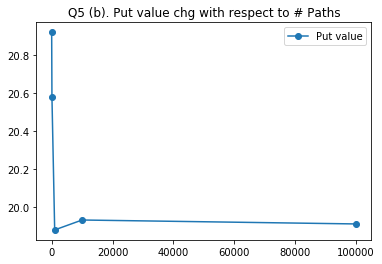

Q5 (c).:
       N  # Paths  Put value
0     3   100000  24.017944
1    10   100000  21.096114
2   100   100000  19.778105
3   250   100000  19.916712
4  1000   100000  19.970550


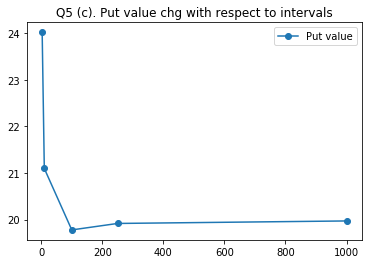

In [5]:
# 5. Longstaff and Schwarts Least Square Method
def laguerre(x, k):
    term_1 = np.exp(-1*x/2) 
    term_2 = np.exp(-1*x/2)*(1 - x) 
    term_3 = np.exp(-1*x/2)*(1 - 2*x + x*x/2) 
    term_4 = np.exp(-1*x/2)*(1 - 3*x + 3*x*x/2 - x**3/6) 
    terms = np.column_stack([term_1, term_2, term_3, term_4]) # combined by column
    return(terms[:, :k])

def lsmc(S0, T, K, r, sd, npath, N, func, k): # npath: number of paths
    dt = T/N
    stocks = stockPrice(S0, T, K, r, sd, N, npath)

    # American put
    # initialize option value, continuation value, and index matrix
    option = np.zeros((npath, N+1))
    index = np.zeros((npath, N+1))
    cv = np.zeros((npath, N+1))
    # assign value at time T
    option[:, N] = np.maximum(K - stocks[:, N], 0)
    index[:, N] = np.where(option[:, N] > 0, 1, 0)

    #discount matrix -> 1 row with exp(-r+dt*i) for i in range(1, step, 1) * npath rows
    discount = np.tile(np.exp(-r*dt* np.arange(0, N + 1, 1)), (npath, 1))

    for i in range(N-1, 0, -1):
        # exercise value at t
        exercise = np.where(K - stocks[:, i] > 0)[0] # ev > 0 row indexes 
        #exercise x paths' index --> for getting discounted cv
        exercisex = list(set(range(npath)) - set(exercise))

        if len(exercisex) == npath:
            # if no exercisable nodes do not exist --> regress with entire St values
            exercise = np.where(stocks[:, i])[0]
            exercisex = list(set(range(npath)) - set(exercise))

        #X = stocks[exercise, i] 
        F = func(stocks[exercise, i], k) 
        # real continued value
        y = np.exp(-1*r*dt)*option[exercise, i+1]
        
        # LSCM continuation value at t
        A = np.dot(np.transpose(F), F)
        b = np.dot(np.transpose(F), y) 
        coef = np.dot(np.linalg.pinv(A), b) # used pinv to prevent a singular matrix in random variables
        cv[exercise, i] = np.dot(F, coef)
        cv[exercisex, i] = np.exp(-1*r*dt)*cv[exercisex, i+1]

        # update index and option array with LSCM result
        index[:, i] = np.where(np.maximum(K - stocks[:, i], 0) > cv[:, i], 1, 0) 
        option[:, i] = np.maximum(np.maximum(K - stocks[:, i], 0), cv[:, i])
        
    #np.argmax(index, axis=1): column-wise -> exercise moment for each path
    final = np.zeros((npath, N+1))
    final[np.arange(0, npath, 1), np.argmax(index, axis=1)] = 1 # early exercise points
    return np.sum(final*discount*option)/npath 


S0 = 200; r = 0.1; sd = 0.3; K = 220; T = 1

# 5. (a)
N = 250; npath = 100000
q5_a = lsmc(S0, T, K, r, sd, npath, N, laguerre, 3)
print('Q5 (a).:', q5_a)

# 5. (b)
N = 250; npath = [10, 100, 1000, 10000, 100000]
q5_b = dict()
for n in npath:
    q5_b[(N, n)] = lsmc(S0, T, K, r, sd, n, N, laguerre, 3)

df_q5_b = pd.concat([pd.DataFrame(list(q5_b.keys())), pd.DataFrame(list(q5_b.values()))], axis=1)
df_q5_b.columns = ['N', '# Paths', 'Put value']
print('Q5 (b).:\n', df_q5_b)

plt.plot(npath, df_q5_b['Put value'], label = 'Put value', marker='o')
plt.title('Q5 (b). Put value chg with respect to # Paths')
plt.legend()
plt.show()

# 5. (c)
N = [3, 10, 100, 250, 1000]; npath = 100000
q5_c = dict()
for n in N:
    q5_c[(n, npath)] = lsmc(S0, T, K, r, sd, npath, n, laguerre, 3)

df_q5_c = pd.concat([pd.DataFrame(list(q5_c.keys())), pd.DataFrame(list(q5_c.values()))], axis=1)
df_q5_c.columns = ['N', '# Paths', 'Put value']
print('Q5 (c).:\n', df_q5_c)

plt.plot(N, df_q5_c['Put value'], label = 'Put value', marker='o')
plt.legend()
plt.title('Q5 (c). Put value chg with respect to intervals')
plt.show()

